In [64]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [85]:
classes = 94
skdim = 10
noise = 2
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [86]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

def uniform_initializer2(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5)

In [87]:
#secret keys
#ascii 0-94
secret_key = uniform_initializer(skdim, classes)
print(secret_key.shape)

torch.Size([10, 94])


In [88]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
    


In [89]:
#One hot net    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon):
        super(One_hot_net, self).__init__()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        self.tail = nn.Linear(feature_len, n_class)

    def forward(self, X):
        X = self.f_encoder.apply_wnoise(X, noise)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return X.transpose(1,0)
    
    def decrypt(self, X):
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return X.transpose(1,0)

In [90]:
parameters = {
    'in_dim': 10,
    'n_class': 10,
    'f_encoder': simple_encoder_wthreshold(1000, 10, 0),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': 100,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}

In [91]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon']).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.005, momentum=0.5)


In [92]:
#create training and testing set
def make_data(size):
    data = torch.rand(size) * classes
    return data.long()

n_epochs = 100
n_batch = 200
batch_size_train = 500
batch_size_test = 500

train_loader = [secret_key[:, make_data(500)] for i in range(n_batch)]
test_loader = [secret_key[:, make_data(500)] for i in range(n_batch)]

print(train_loader[0].shape)

torch.Size([10, 500])


In [93]:
train_losses = []
test_losses = []

In [94]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(float(train_loss))
    print('Epoch: {}, Train set: Avg. loss: {:.6f}'.format(epoch,
        train_loss))
    return model, optimizer
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += nn.MSELoss()(output, data).item()
    test_loss /= len(test_loader)
    test_losses.append(float(test_loss))
    #print(output[:,0]-data[:,0])
    print('Test set: Avg. loss: {:.6f}'.format(
        test_loss))
    return test_loss

In [95]:
model_name = "crypto_net1"
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)

Epoch: 1, Train set: Avg. loss: 0.518317
Test set: Avg. loss: 0.198323
Epoch: 2, Train set: Avg. loss: 0.160629
Test set: Avg. loss: 0.140666
Epoch: 3, Train set: Avg. loss: 0.135653
Test set: Avg. loss: 0.130570
Epoch: 4, Train set: Avg. loss: 0.126191
Test set: Avg. loss: 0.123714
Epoch: 5, Train set: Avg. loss: 0.120896
Test set: Avg. loss: 0.119684
Epoch: 6, Train set: Avg. loss: 0.116661
Test set: Avg. loss: 0.114497
Epoch: 7, Train set: Avg. loss: 0.112103
Test set: Avg. loss: 0.109015
Epoch: 8, Train set: Avg. loss: 0.107045
Test set: Avg. loss: 0.105983
Epoch: 9, Train set: Avg. loss: 0.105503
Test set: Avg. loss: 0.104672
Epoch: 10, Train set: Avg. loss: 0.102252
Test set: Avg. loss: 0.100265
Epoch: 11, Train set: Avg. loss: 0.099806
Test set: Avg. loss: 0.098326
Epoch: 12, Train set: Avg. loss: 0.098636
Test set: Avg. loss: 0.096718
Epoch: 13, Train set: Avg. loss: 0.096929
Test set: Avg. loss: 0.095227
Epoch: 14, Train set: Avg. loss: 0.095274
Test set: Avg. loss: 0.093749
E

In [96]:
print(len(train_losses), len(test_losses))
#print(train_losses)

100 100


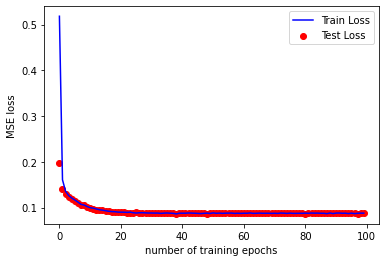

In [97]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.scatter(range(len(test_losses)), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training epochs')
plt.ylabel('MSE loss')
plt.show()

In [98]:
#Testing Encoded sentence
message = "It is time to test the model on real-world data"#. We must choose a sentence and an image. We choose the following sentence from Wikipedia: Anthony Edward \"Tony\" Stark is a character portrayed by Robert Downey Jr. in the MCU film franchise and for the image, we use the same Tony Stark’s image from the beginning of the article. The following code is used to embedding and extracting the message:"


In [99]:
message_index = [(ord(c)-32) for c in message]
print(message_index)
secret_message = secret_key[:, message_index]#.to(device)
output = model1(secret_message)
print(output[:,0]-secret_message[:,0])

[41, 84, 0, 73, 83, 0, 84, 73, 77, 69, 0, 84, 79, 0, 84, 69, 83, 84, 0, 84, 72, 69, 0, 77, 79, 68, 69, 76, 0, 79, 78, 0, 82, 69, 65, 76, 13, 87, 79, 82, 76, 68, 0, 68, 65, 84, 65]
tensor([ 0.0208, -0.5479,  0.3699, -0.5435, -0.2456,  0.0691, -0.2448,  0.1447,
         0.2614, -0.2412], device='cuda:0', grad_fn=<SubBackward0>)


In [100]:
def encrypt(message, model, secret_key):
    message_index = [(ord(c)-32) for c in message]
    print(message_index)
    #print(secret_key)
    #sk = secret_key.cpu()
    #print(sk.shape, sk.device)
    secret_message = secret_key[:, message_index]#.to(device)
    print(secret_message[:,0])
    return model.f_encoder.apply_wnoise(secret_message, noise)

In [101]:
encrypted_message = encrypt(message, model1, secret_key)

[41, 84, 0, 73, 83, 0, 84, 73, 77, 69, 0, 84, 79, 0, 84, 69, 83, 84, 0, 84, 72, 69, 0, 77, 79, 68, 69, 76, 0, 79, 78, 0, 82, 69, 65, 76, 13, 87, 79, 82, 76, 68, 0, 68, 65, 84, 65]
tensor([ 0.4421,  1.5233, -1.5746,  1.3358,  1.4714, -1.8763, -0.1206, -1.6462,
        -1.1984,  0.5341], device='cuda:0')


In [102]:
print(encrypted_message, encrypted_message.shape)

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.]], device='cuda:0') torch.Size([1000, 47])


In [103]:
def determine_letter(vec, secret_key):
    ind=torch.argmin(torch.norm(secret_key-vec,dim=0))
    #print(ind)
    return chr(ind+32)

def decrypt(encrypted_message, model, secret_key):
    m = ""
    raw_m = model.decrypt(encrypted_message)
    #print(raw_m[:,0], secret_key[:,41], torch.norm(raw_m[:,0]-secret_key[:,41]))
    for i in range(raw_m.shape[1]):
        m+=(determine_letter(raw_m[:,i].view(raw_m.shape[0],1),secret_key))
    return m

In [104]:
decrypted_m = decrypt(encrypted_message, model1, secret_key)
print(decrypted_m)

It is time to test the model on real-world data
